# Train Fast R-CNN
This code is inspired by this [link](https://towardsdatascience.com/understanding-and-implementing-faster-r-cnn-a-step-by-step-guide-11acfff216b0). <br>
The following image describes the topology of the Fast R-CNN

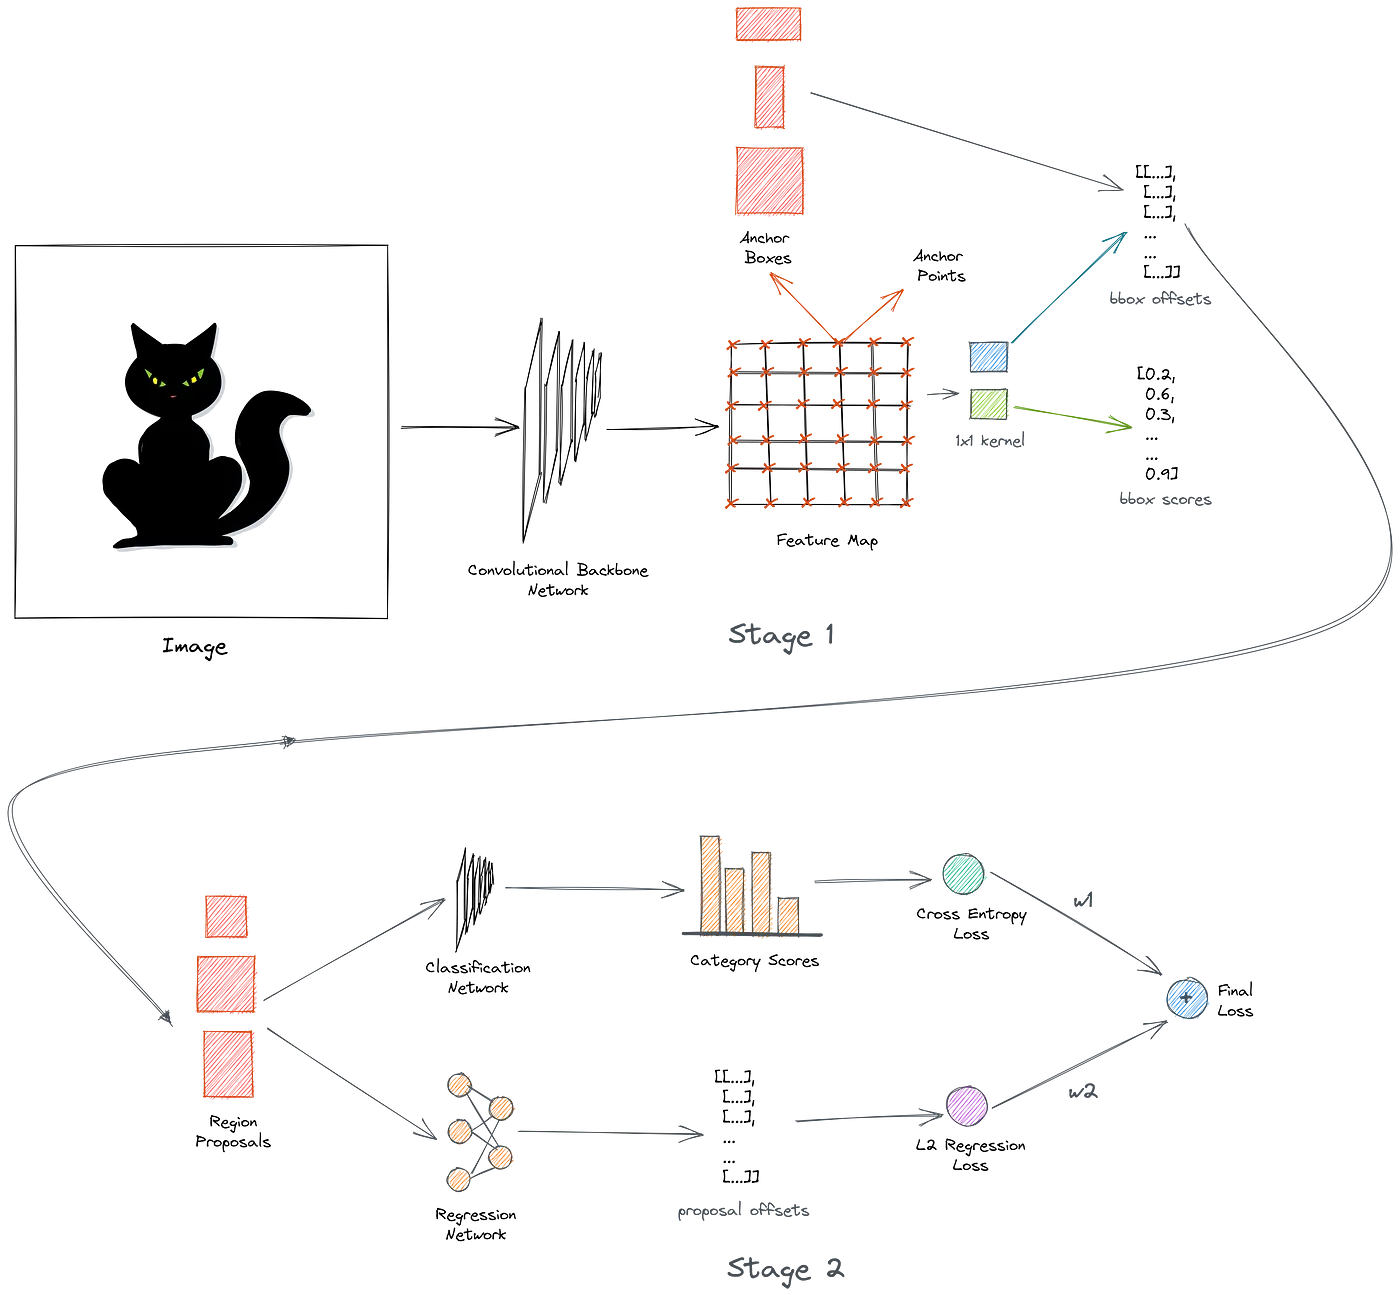

In [1]:
!pip install pycocotools

In [2]:
from typing import Tuple, List, Dict, Optional
from collections import OrderedDict
import os
import numpy as np
import json
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torchvision

from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader, random_split

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.optim import Adam

from torchvision.models.detection.roi_heads import fastrcnn_loss
from torchvision.models.detection.rpn import concat_box_prediction_layers

In [3]:
class COCODataset(Dataset):
    def __init__(self, root_dir, annotation_file, transform=None, image_prefix="train_", file_type=".png"):
        self.root_dir = root_dir
        self.transform = transform
        self.image_prefix = image_prefix
        self.file_type = file_type

        # Create dict with image ID as key and bboxes and categories as arrays
        self.image_dict = {}
        # Load the annotations from the JSON file
        with open(annotation_file) as f:
            data = json.load(f)
        # Filter annotations by category_id == 3 (Dental issues)
        filtered_annotations = [annotation for annotation in data['annotations'] if annotation['category_id'] == 3]
        for annotation in filtered_annotations:
            image_id = annotation['image_id']
            bbox = list(map(int, annotation['bbox']))
            # Convert bbox to [x_min, y_min, x_max, y_max]
            bbox = [bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]]
            category_id = annotation['category_id']

            # Check if the image file exists
            img_path = os.path.join(self.root_dir, self.image_prefix + str(image_id) + self.file_type)
            if not os.path.exists(img_path):
                continue

            if image_id not in self.image_dict:
                self.image_dict[image_id] = {'boxes': [], 'labels': []}
        
            # Append the bbox and category_id to the respective lists
            self.image_dict[image_id]['boxes'].append(bbox)
            self.image_dict[image_id]['labels'].append(category_id)

    def __len__(self):
        return len(self.image_dict)

    def __getitem__(self, idx):
        # Get the image_id from the keys of the image_dict
        image_id = list(self.image_dict.keys())[idx]
        # Construct the image path using the image_id
        img_path = os.path.join(self.root_dir, self.image_prefix + str(image_id) + self.file_type)
        # Open the image
        image = Image.open(img_path).convert("L")
        # Apply the transform if it's not None
        if self.transform:
            image = self.transform(image)
        # Get the annotations for this image
        annotations = self.image_dict[image_id]
        
        # Convert the annotations to the expected format
        targets = {}
        targets['boxes'] = torch.as_tensor(annotations['boxes'], dtype=torch.float32)
        targets['labels'] = torch.as_tensor(annotations['labels'], dtype=torch.int64)
        return image, targets

In [4]:
BATCH_SIZE = 16
NUM_WORKERS = 1

data_dir = './dentex_dataset/coco/disease_all/train2017'
annotations = './dentex_dataset/coco/disease_all/annotations/instances_train2017.json'

# Define the transformation
transform = transforms.Compose([
    transforms.Resize((512, 512)),  # Resize to 256x256
    transforms.ToTensor(),  # Convert PIL Image to Tensor
])

# Create the dataset
dataset = COCODataset(root_dir=data_dir, annotation_file=annotations, transform=transform)

# Define the size of the validation set
val_size = int(0.2 * len(dataset))  # 20% for validation
train_size = len(dataset) - val_size

# Split the dataset into training and validation sets
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Pad all the annotations to have the same shape
def collate_fn(batch):
    max_num_boxes = max(len(item[1]) for item in batch)
    
    images = []
    targets = []
    
    for image, target in batch:
        images.append(image)
        
        # Pad target if it has fewer boxes
        if len(target) < max_num_boxes:
            target = np.pad(target, ((0, max_num_boxes - len(target)), (0, 0)), mode='constant')
        
        targets.append(target)
    
    # Convert each dictionary in targets to tensor
    targets = [{k: torch.as_tensor(v) for k, v in t.items()} for t in targets]
    
    return images, targets

# Define your data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, collate_fn=collate_fn)

In [5]:
lr = 0.0001

# Load a pre-trained model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)

# Replace the classifier with a new one, that has num_classes which is user-defined
num_classes = 4  # 1 class (person) + background
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Define your optimizer
optimizer = Adam(model.parameters(), lr=lr)

/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/jovyan/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 222MB/s]


In [6]:
# RCNN does not output losses, so it needs to be comupted, see https://stackoverflow.com/questions/71288513/how-can-i-determine-validation-loss-for-faster-rcnn-pytorch

def eval_forward(model, images, targets):
    # type: (List[Tensor], Optional[List[Dict[str, Tensor]]]) -> Tuple[Dict[str, Tensor], List[Dict[str, Tensor]]]
    """
    Args:
        images (list[Tensor]): images to be processed
        targets (list[Dict[str, Tensor]]): ground-truth boxes present in the image (optional)
    Returns:
        result (list[BoxList] or dict[Tensor]): the output from the model.
            It returns list[BoxList] contains additional fields
            like `scores`, `labels` and `mask` (for Mask R-CNN models).
    """
    model.eval()

    original_image_sizes: List[Tuple[int, int]] = []
    for img in images:
        val = img.shape[-2:]
        assert len(val) == 2
        original_image_sizes.append((val[0], val[1]))

    images, targets = model.transform(images, targets)

    # Check for degenerate boxes
    if targets is not None:
        for target_idx, target in enumerate(targets):
            boxes = target["boxes"]
            degenerate_boxes = boxes[:, 2:] <= boxes[:, :2]
            if degenerate_boxes.any():
                # print the first degenerate box
                bb_idx = torch.where(degenerate_boxes.any(dim=1))[0][0]
                degen_bb: List[float] = boxes[bb_idx].tolist()
                raise ValueError(
                    "All bounding boxes should have positive height and width."
                    f" Found invalid box {degen_bb} for target at index {target_idx}."
                )

    features = model.backbone(images.tensors)
    if isinstance(features, torch.Tensor):
        features = OrderedDict([("0", features)])
    model.rpn.training=True
    #model.roi_heads.training=True


    #####proposals, proposal_losses = model.rpn(images, features, targets)
    features_rpn = list(features.values())
    objectness, pred_bbox_deltas = model.rpn.head(features_rpn)
    anchors = model.rpn.anchor_generator(images, features_rpn)

    num_images = len(anchors)
    num_anchors_per_level_shape_tensors = [o[0].shape for o in objectness]
    num_anchors_per_level = [s[0] * s[1] * s[2] for s in num_anchors_per_level_shape_tensors]
    objectness, pred_bbox_deltas = concat_box_prediction_layers(objectness, pred_bbox_deltas)
    # apply pred_bbox_deltas to anchors to obtain the decoded proposals
    # note that we detach the deltas because Faster R-CNN do not backprop through
    # the proposals
    proposals = model.rpn.box_coder.decode(pred_bbox_deltas.detach(), anchors)
    proposals = proposals.view(num_images, -1, 4)
    proposals, scores = model.rpn.filter_proposals(proposals, objectness, images.image_sizes, num_anchors_per_level)

    proposal_losses = {}
    assert targets is not None
    labels, matched_gt_boxes = model.rpn.assign_targets_to_anchors(anchors, targets)
    regression_targets = model.rpn.box_coder.encode(matched_gt_boxes, anchors)
    loss_objectness, loss_rpn_box_reg = model.rpn.compute_loss(
        objectness, pred_bbox_deltas, labels, regression_targets
    )
    proposal_losses = {
        "loss_objectness": loss_objectness,
        "loss_rpn_box_reg": loss_rpn_box_reg,
    }

    #detections, detector_losses = model.roi_heads(features, proposals, images.image_sizes, targets)
    image_shapes = images.image_sizes
    proposals, matched_idxs, labels, regression_targets = model.roi_heads.select_training_samples(proposals, targets)
    box_features = model.roi_heads.box_roi_pool(features, proposals, image_shapes)
    box_features = model.roi_heads.box_head(box_features)
    class_logits, box_regression = model.roi_heads.box_predictor(box_features)

    result: List[Dict[str, torch.Tensor]] = []
    detector_losses = {}
    loss_classifier, loss_box_reg = fastrcnn_loss(class_logits, box_regression, labels, regression_targets)
    detector_losses = {"loss_classifier": loss_classifier, "loss_box_reg": loss_box_reg}
    boxes, scores, labels = model.roi_heads.postprocess_detections(class_logits, box_regression, proposals, image_shapes)
    num_images = len(boxes)
    for i in range(num_images):
        result.append(
            {
                "boxes": boxes[i],
                "labels": labels[i],
                "scores": scores[i],
            }
        )
    detections = result
    detections = model.transform.postprocess(detections, images.image_sizes, original_image_sizes)  # type: ignore[operator]
    model.rpn.training=False
    model.roi_heads.training=False
    losses = {}
    losses.update(detector_losses)
    losses.update(proposal_losses)
    return losses, detections

In [7]:
def train_model(model, train_dataloader, validation_dataloader, optimizer, num_epochs=30):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for images, annotations in train_dataloader:
            images = [image.to(device) for image in images]
            annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
            loss_dict = model(images, annotations)
            losses = sum(loss for loss in loss_dict.values())
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
            train_loss += losses.item()
        avg_train_loss = train_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)

        model.eval()
        with torch.no_grad():
            val_loss = 0
            for images, annotations in validation_dataloader:
                images = [image.to(device) for image in images]
                annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
                loss_dict, _ = eval_forward(model, images, annotations)
                val_loss += sum(loss.sum().item() if loss.dim() else loss.item() for loss in loss_dict.values()) if loss_dict else 0
            avg_val_loss = val_loss / len(validation_dataloader)
            val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}")

    return model, train_losses, val_losses

In [8]:
model, train_losses, val_losses = train_model(
    model=model,
    train_dataloader=train_loader,
    validation_dataloader=val_loader,
    optimizer=optimizer,
    num_epochs=30
)

Epoch 1/30, Training Loss: 51.036192893981934, Validation Loss: 31.647534301197993
Epoch 2/30, Training Loss: 31.156843900680542, Validation Loss: 28.69318752176514
Epoch 3/30, Training Loss: 28.891485571861267, Validation Loss: 31.856831540250766
Epoch 4/30, Training Loss: 31.06695330142975, Validation Loss: 29.01986499895611
Epoch 5/30, Training Loss: 29.401280403137207, Validation Loss: 27.162292459382883
Epoch 6/30, Training Loss: 28.229932069778442, Validation Loss: 27.102445619957912
Epoch 7/30, Training Loss: 27.619481325149536, Validation Loss: 27.85829678834773
Epoch 8/30, Training Loss: 27.950557112693787, Validation Loss: 26.966112863357413
Epoch 9/30, Training Loss: 27.616427898406982, Validation Loss: 33.13051351842208
Epoch 10/30, Training Loss: 30.35196840763092, Validation Loss: 28.307713897640042
Epoch 11/30, Training Loss: 29.106648683547974, Validation Loss: 27.747936021982696
Epoch 12/30, Training Loss: 28.42243993282318, Validation Loss: 26.777957901331547
Epoch 13

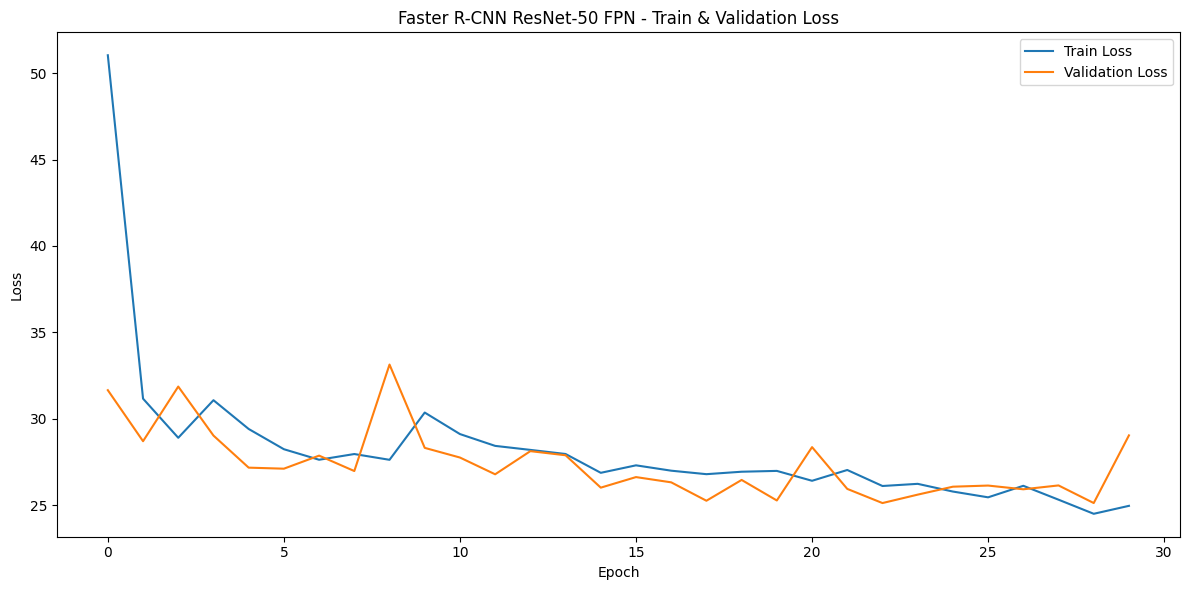

In [12]:
plt.figure(figsize=(12, 6))
plt.title("Faster R-CNN ResNet-50 FPN - Train & Validation Loss")

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend()
plt.tight_layout()

plt.savefig('train_val_loss.png', dpi=300)

plt.show()

{'boxes': tensor([], device='cuda:0', size=(0, 4), grad_fn=<StackBackward0>), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0', grad_fn=<IndexBackward0>)}


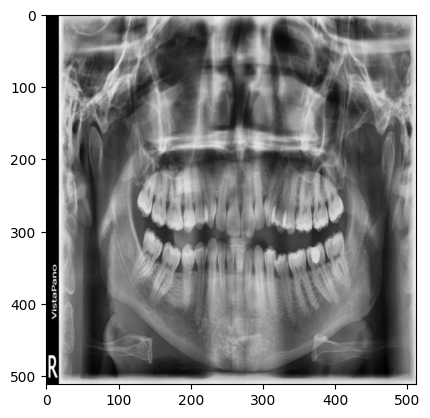

In [14]:
# Python
import matplotlib.pyplot as plt
import numpy as np

# Your existing code
import matplotlib.patches as patches
from PIL import Image

# Load the image
image_path = './dentex_dataset/segmentation/enumeration32/xrays/train_2.png'
image = Image.open(image_path).convert("RGB")

# Convert the image to PyTorch tensor
image_tensor = transform(image)

# Add an extra dimension because the model expects batches
image_tensor = image_tensor.unsqueeze(0)
image_tensor = image_tensor.to('cuda')

# Get the model's output
model.eval()
output = model(image_tensor)[0]
print(output)

# Convert the image tensor back to numpy array
image_tensor = image_tensor.cpu().squeeze(0).permute(1, 2, 0).numpy()

# Create a matplotlib figure
fig, ax = plt.subplots(1)

# Display the image
ax.imshow(np.clip(image_tensor, 0, 1))

# Get the bounding boxes, labels and scores from the model's output
boxes = output['boxes'].detach().cpu().numpy()
labels = output['labels'].detach().cpu().numpy()
scores = output['scores'].detach().cpu().numpy()

# Draw each bounding box
for box, label, score in zip(boxes, labels, scores):
    # Create a Rectangle patch
    rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=1, edgecolor='r', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

    # Add label and score text
    plt.text(box[0], box[1], f'{label}: {score:.2f}', color='white')

# Show the figure
plt.show()

# 